# Circle radius test
Learn the function $f: \mathbb{R}^2 \rightarrow \mathbb{R}$ where $f:\bf{x} \mapsto |x|$ with a deep neural network and compute the mutual information changes between the input, the different layer outputs and the output.

In [354]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Wedge

import scipy.spatial as ss
from scipy.special import digamma
from math import log

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.optimizers import Adam
import keras

In [2]:
def plot_learning_curve(fitting_history):
    plt.clf()
    plt.figure(figsize=(10, 10))

    plt.subplot(2,1,1)
    plt.plot(fitting_history['loss'], color='steelblue')
    plt.plot(fitting_history['val_loss'], color='orange')
    plt.legend(['Training loss', 'Testing loss'])

    plt.subplot(2,1,2)
    plt.plot(fitting_history['acc'], color='steelblue')
    plt.plot(fitting_history['val_acc'], color='orange')
    plt.legend(['Training accuracy', 'Testing accuracy'])

    plt.show()

In [313]:
def plot_decision_boundaries(model, radius):
    grid = np.mgrid[-2:2:100j, -2:2:100j]
    samples = np.concatenate(list(np.stack(grid.T, axis=1)), axis=0)
    predictions = model.predict_classes(samples)

    samples_0 = samples[predictions == 0]
    samples_1 = samples[predictions == 1]

    plt.clf()

    fig, ax = plt.subplots()
    fig.set_size_inches((8, 8))
    ax.add_patch(Wedge((0, 0), radius, 0, 360, width=0.05, color='red'))
    plt.scatter(samples_0[:, 0], samples_0[:,1], c='steelblue',  marker='+')
    plt.scatter(samples_1[:, 0], samples_1[:, 1], c='orange', marker='o')

    plt.show()

## Define function and generate random samples

In [291]:
radius = 0.8

def f(x):
    return np.where(np.sqrt(np.sum(x * x)) > radius, 1, 0)

In [339]:
dimensions = 2

np.random.seed(42)
X_train = np.random.uniform(-1, 1, size=[100000, dimensions])
Y_train = np.apply_along_axis(f, 1, X_train)

X_test = np.random.uniform(-1, 1, size=[1000, dimensions])
Y_test = np.apply_along_axis(f, 1, X_test)

In [340]:
pd.DataFrame(Y_train).describe()

,0
count,100000.000000
mean,0.494740
std,0.499975
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


## Mutual information and entropy functions

In [341]:
def log_or_0(x):
    return np.log(x) if x > 0 else 0

np_log_or_0 = np.vectorize(log_or_0)

In [342]:
def entropy(x, k=3, base=2, seed=None):
    assert k < len(x)
    d, N = len(x[0]), len(x)
    
    if seed:
        np.random.seed(seed)
    intens = 1e-10
    small_noise_x = x + intens * np.random.rand(d)
    
    tree = ss.cKDTree(small_noise_x)
    nn = tree.query(small_noise_x, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]

    const = digamma(N) - digamma(k) + d * log(2)

    return (const + d * np.mean(np_log_or_0(nn))) / log(base)

In [343]:
def avg_digamma(points, dvec):
    N = len(points)
    tree = ss.cKDTree(points)
    avg = 0.
    
    for i in range(N):
        dist = dvec[i]
        num_points = len(tree.query_ball_point(points[i], dist - 1e-15, p=float('inf')))
        avg += digamma(num_points) / N
        
    return avg

In [344]:
def mutual_information(x, y, k=3, base=2, seed=None):
    assert len(x) == len(y), "Lists should have same length"
    assert k <= len(x) - 1, "Set k smaller than num. samples - 1"
    
    if seed:
        np.random.seed(seed)
    intens = 1e-6
    x_noise = x + intens * np.random.rand(len(x[0]))
    y_noise = y + intens * np.random.rand(len(y[0]))
    points = np.concatenate([x_noise, y_noise], axis=1)
                   
    tree = ss.cKDTree(points)
    dvec = tree.query(points, k + 1, p=float('inf'), n_jobs=-1)[0][:, -1:]
       
    a, b, c, d = avg_digamma(x, dvec), avg_digamma(y, dvec), digamma(k), digamma(len(x))
    return (-a - b + c + d) / log(base)

In [345]:
def discrete_entropy(x):
    x_df = pd.DataFrame(x)
    probabilities = (x_df
        .reset_index()
        .groupby(list(x_df.columns))
        .count()) / x.shape[0]
    
    return - np.sum(probabilities * np.log2(probabilities))[0]

In [346]:
def mixed_mutual_information(x, y, k=3, base=2, seed=None):
    overallentropy = entropy(x, k, base, seed=seed)

    n = len(y)
    word_dict = dict()
    for i in range(len(y)):
        if type(y[i]) == list:
            y[i] = tuple(y[i])
    for sample in y:
        word_dict[sample] = word_dict.get(sample, 0) + 1. / n
    yvals = list(set(word_dict.keys()))

    mi = overallentropy
    for yval in yvals:
        xgiveny = [x[i] for i in range(n) if y[i] == yval]
        mi -= word_dict[yval] * entropy(xgiveny, k, base, seed=seed)
    return np.abs(mi)

## Callback which gathers mutual information during training

In [347]:
def output_of_nth_layer(n, x, model):
    intermediate_layer_model = Model(
        inputs=model.input,
        outputs=model.layers[n].output)
    return intermediate_layer_model.predict(x)

def all_layers_outputs(x, model):
    return [x] + [output_of_nth_layer(n, x, model) for n in range(len(model.layers))]

def get_mutual_information_X(x_0, layers_output, show_output=True):
    def compute_next(x):
        if show_output:
            print('Computing I(X, H_{})'.format(x[0]))
        return mutual_information(x_0, x[1])
    
    return list(map(compute_next, enumerate(layers_output)))

def get_mutual_information_Y(y_0, layers_output, k=None, show_output=True):
    def compute_next(x):
        if show_output:
            print('Computing I(H_{}, Y)'.format(x[0]))
        return mixed_mutual_information(x[1], y_0, k)
    
    return list(map(compute_next, enumerate(layers_output)))

In [348]:
class CollectMutualInformation(keras.callbacks.Callback):
    def __init__(self, period_in_epochs, x_test, y_test, y_k=None, show_output=True):
        self.period_in_epochs = period_in_epochs
        self.mutual_information_X = []
        self.mutual_information_Y = []
        self.x_test = x_test
        self.y_test = y_test
        self.y_k = y_k
        self.show_output = show_output
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.period_in_epochs == 0:
            layers_output = all_layers_outputs(self.x_test, self.model)
            self.mutual_information_X.append(
                get_mutual_information_X(self.x_test, layers_output, show_output=self.show_output))
            self.mutual_information_Y.append(
                get_mutual_information_Y(self.y_test, layers_output, k=self.y_k, show_output=self.show_output))

In [349]:
class PlotDecisionBoundaries(keras.callbacks.Callback):
    def __init__(self, period_in_epochs, radius, epochs):
        self.period_in_epochs = period_in_epochs
        self.radius = radius
        self.epochs = epochs
        
    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.period_in_epochs == 0:
            print('Epoch: {}/{}'.format(epoch, self.epochs))
            plot_decision_boundaries(self.model, self.radius)

## Build a feed forward neural network

In [350]:
ffnn = Sequential([
    Dense(8, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(7, activation='relu'),
    Dense(6, activation='relu'),
    Dense(5, activation='relu'),
    Dense(4, activation='relu'),
    Dense(3, activation='relu'),
    Dense(2, activation='sigmoid')
])

ffnn.compile(metrics=['accuracy'], optimizer=Adam(), loss='categorical_crossentropy')

Epoch: 0/100


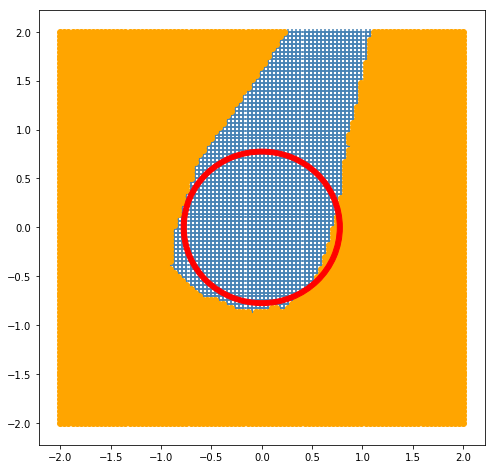

Epoch: 10/100


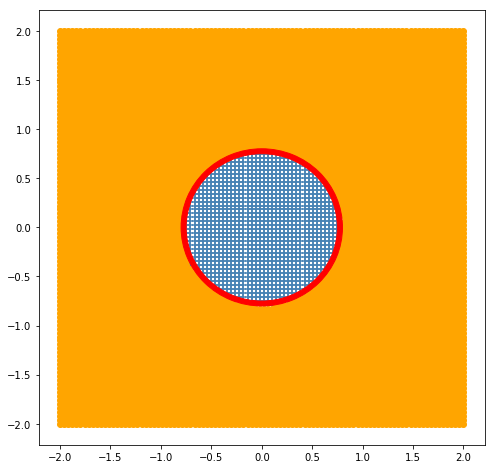

Epoch: 20/100


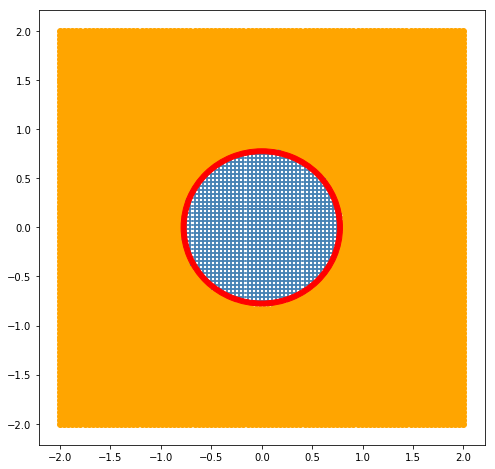

Epoch: 30/100


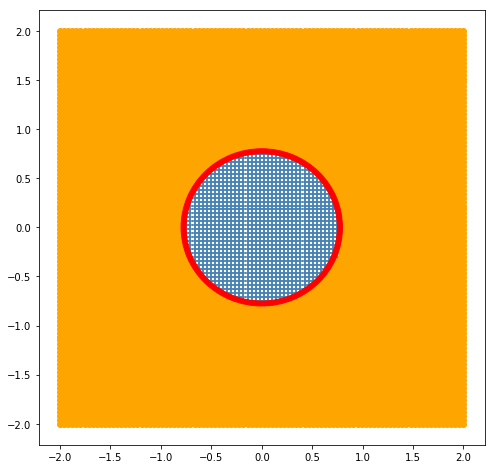

Epoch: 40/100


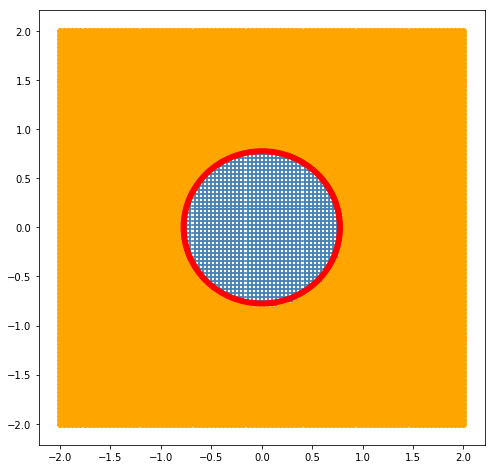

Epoch: 50/100


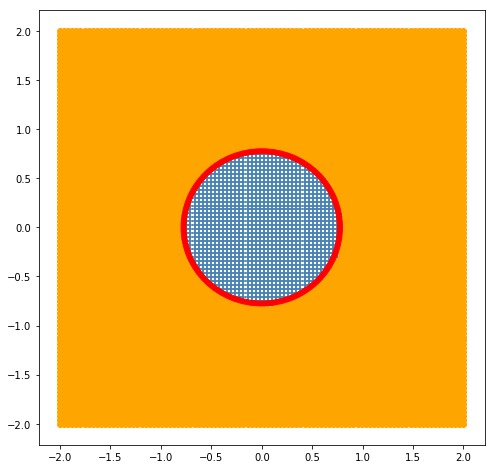

Epoch: 60/100


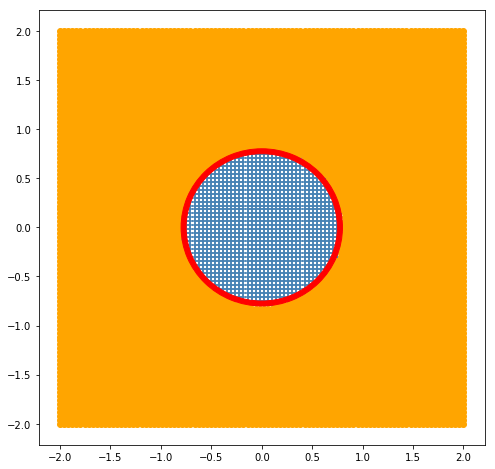

Epoch: 70/100


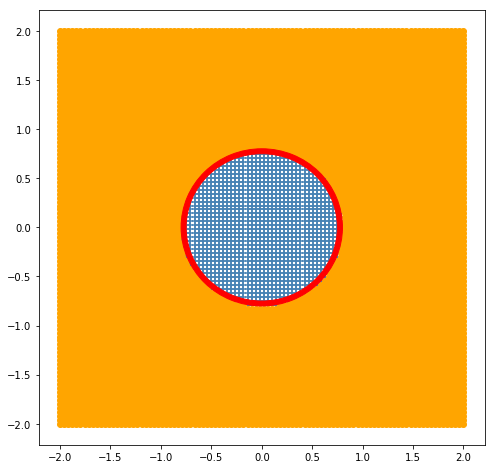

Epoch: 80/100


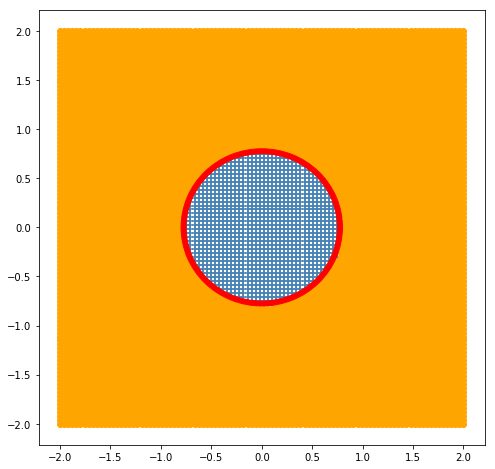

Epoch: 90/100


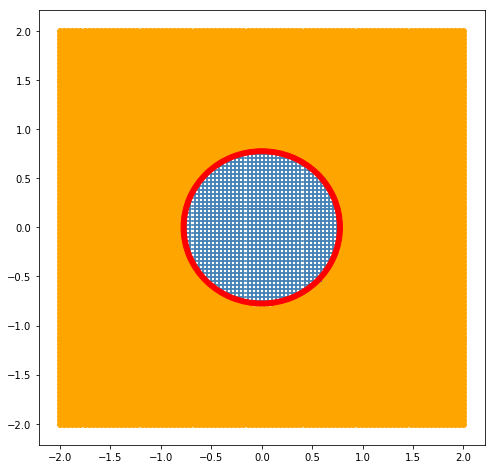

CPU times: user 1min 30s, sys: 7.2 s, total: 1min 37s
Wall time: 1min 7s


In [351]:
%%time
number_of_epochs = 100
batch_size = 1000
collect_mutual_information = CollectMutualInformation(10, X_test, Y_test, y_k=10, show_output=False)
decision_boundaries = PlotDecisionBoundaries(10, radius, number_of_epochs)

ffnn_fitting = ffnn.fit(
    X_train, 
    to_categorical(Y_train),
    validation_data=(X_test, to_categorical(Y_test)),
    callbacks=[collect_mutual_information, decision_boundaries],
    epochs=number_of_epochs,
    batch_size=batch_size,
    verbose=0)

In [352]:
print('Test accuracy: {}'.format(ffnn.evaluate(X_test, to_categorical(Y_test))[1]))

1000/1000 [==============================] - 0s 64us/step
Test accuracy: 0.991


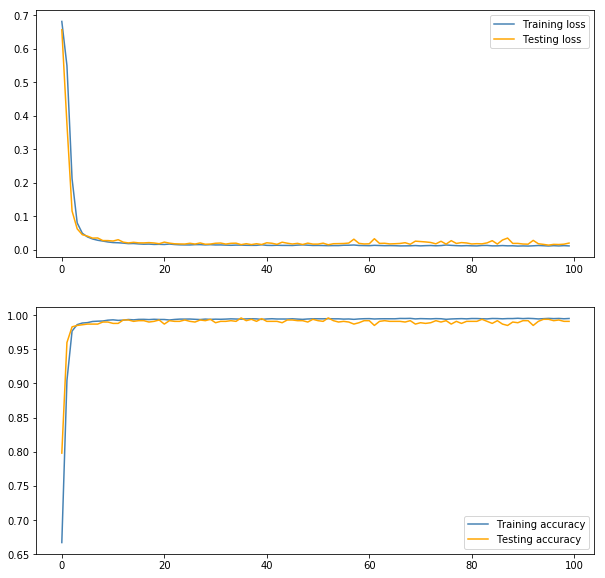

In [353]:
plot_learning_curve(ffnn_fitting.history)

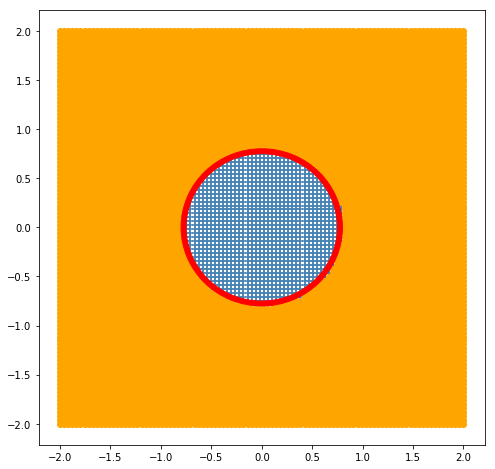

In [332]:
plot_decision_boundaries(ffnn, radius)

## Mutual information through time

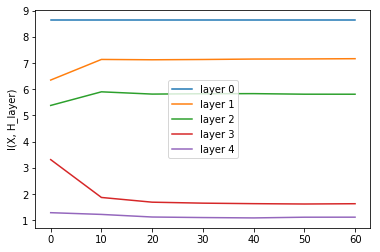

In [335]:
lines = []
for i, layer in enumerate(list(np.array(collect_mutual_information.mutual_information_X).T)):
    line, = plt.plot(np.arange(len(layer)) * 10, layer, label='layer {}'.format(i))
    lines.append(line)
    
plt.legend(handles=lines)
plt.ylabel('I(X, H_layer)')
plt.xlabel = 'Epochs'
plt.show()

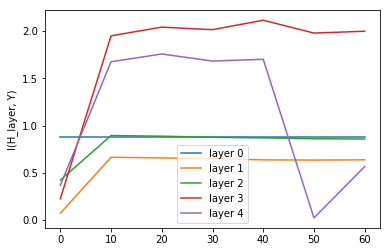

In [336]:
lines = []
for i, layer in enumerate(list(np.array(collect_mutual_information.mutual_information_Y).T)):
    line, = plt.plot(np.arange(len(layer)) * 10, layer, label='layer {}'.format(i))
    lines.append(line)
    
plt.legend(handles=lines)
plt.ylabel('I(H_layer, Y)')
plt.xlabel = 'Epochs'
plt.show()